# Simulation: Matched Filter Beamformer for an Open Sphere

In this notebook, the matched filter beamformer is realized
in the time domain.

* A Dirac-shaped plane wave is captured on the surface of an
open sphere by a finite number of microphones
* The matched filter beamformer is performed in the
spherical harmonics (modal) domain
* The impulse response of the beamformer is obtained
through the spherical harmonics expansion

In [1]:
import micarray
import irutils
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve as conv, freqz
from scipy.special import eval_legendre as legendre
from micarray.util import db
%matplotlib inline

import importlib
importlib.reload(irutils)

def sph2cart(azi, colat, r):
    x = r * np.cos(azi) * np.sin(colat)
    y = r * np.sin(azi) * np.sin(colat)
    z = r * np.cos(colat)
    return x, y, z

#### Captured sound field

* $s(\boldsymbol{x}_q, t) =
\delta\left(t + \tfrac{\langle\boldsymbol{n}_\text{pw},
\boldsymbol{x}_q\rangle}{c}\right)$
: captured signal by the $q$-th microphone
* $\boldsymbol{n}_\text{pw}=(1, \theta_\text{pw}, \phi_\text{pw})$
: unit vector pointing the direction of arrival of the plane wave
* $\boldsymbol{x}_q = (R, \theta_q, \phi_q), \: q=1,\ldots,Q$
: microphone positions, with $Q$ denoting the number of microphones

The parameter `array_order` determines the 
number of microphones and their distribution on the sphere.
The microphone array is designed in such a way that
it is able to capture the sound field of the given bandwidth
without considerable spatial aliasing.
The aliasing frequency `f_alias` is typically approximated as
$f_\text{alias} = \tfrac{c N}{2\pi R}$.

The captured impuse responses are computed
by using the Lagrange fractional delay filter.
See `irutils.py`.

* `x : (Q, 3)` microphone positions in the Cartesian coordinate
* `s : (L, Q)` captured sound field
* `L` : length of the time domain signal `s`
* `Q` : number of microphones

In [2]:
c = 343  # speed of sound
fs = 44100 * 2  # sampling frequency

# Incident plane wave
azi_pw, colat_pw = 0 * np.pi, 0.5 * np.pi
npw = sph2cart(azi_pw, colat_pw, 1)  # direction-of-arrival

# Microphone array
R = 0.25
array_order = 50
azi, colat, wq = micarray.modal.angular.grid_gauss(array_order)
x = np.column_stack(sph2cart(azi, colat, R))
Q = len(azi)  # Number of microphones
f_alias = c * array_order / 2 / np.pi / R  # aliasing frequency

# Sound field (impulse responses)
delay, amplitude = irutils.greens_plane(npw, x, doa=True)
shift, signal, fs = irutils.fractional_delay(delay, amplitude, fs,
                                             oversample=2, fdfilt_order=11)
overall_shift, s = irutils.ir_matrix(shift, signal)
L = len(s)

The spherical harmonics coefficients are computed
by approximating the surface integral by a finite summation.
Each sampled signal is weighted by the quadrature weight `wq`
which cope with the non-uniform distribution of the arrary.
    
\begin{align}
\mathring{s}_{nm}(t)
=& \int_{0}^{2\pi} \int_{0}^{\pi} s(\boldsymbol{x}, t)
Y_{nm}^{\ast}(\hat{\boldsymbol{x}}) \sin\vartheta \:\text{d}\vartheta
\: \text{d}\varphi \\
\approx& \sum_{q=1}^{Q} w_q \: s(\boldsymbol{x}_q, t) \: Y_{nm}^{\ast}(\hat{\boldsymbol{x}}_q)
\end{align}
* $\mathring{s}_{nm}(t)$ : modal coefficient of the sound field
* $\hat{\boldsymbol{x}} = \frac{\boldsymbol{x}}{\Vert\boldsymbol{x}\Vert}
= (1, \theta, \phi)$ : unit vector pointing $\boldsymbol{x}$
* $w_q$ : quadrature weight

The modal coefficients are computed up to a finite order `bf_order`,
which is the spatial bandwidth of the modal beamformer.
Notice that the latter is not necessarily the same as `array_order`.
The output of the beamformer will be computed for
look directions in the horizontal plane $\theta_l=\tfrac{\pi}{2}$.

* `snm : (L, (bf_order + 1)**2)` modal coefficients of the sound field
* `Ynm_q : (Q, (bf_order + 1)**2)` spherical harmonics evaluated at the microphone positions
* `Ynm_l : (N_angle, (bf_order + 1**2))` spherical harmonics evaluated at the look directions
* `N_angle` : number of look directions

In [3]:
# Matched filter beamforming
bf_order = 7
f_N = c * bf_order / 2 / np.pi / R  # critical frequency
Ynm_q = micarray.modal.angular.sht_matrix(bf_order, azi, colat, weights=wq)
snm = np.squeeze(np.matmul(np.conj(Ynm_q.T), s[:, :, np.newaxis]))

# Look directions in the horizontal plane
N_angle = 360
azi_l, colat_l = np.linspace(-np.pi, np.pi, num=N_angle), 0.5 * np.pi
Ynm_l = micarray.modal.angular.sht_matrix(bf_order, azi_l, colat_l)

The next step is to convolve each modal coefficient
with the Legendre polynomial,

\begin{align}
\mathring{v}_{nm}(t)
=& \frac{2 \pi c}{r} P_{n}(\tfrac{c}{r}t)
\ast_{t} s_{nm}(t),
\end{align}

and finally the beamformer output (impulse response) is
obtained by the modal expansion,

\begin{align}
v(\boldsymbol{n}_l, t)
=& \sum_{n=0}^{N} \sum_{m=-n}^{n}
\mathring{v}_{nm}(t) Y_{nm}(\boldsymbol{n}_l)
\end{align}

where
* $v(\boldsymbol{n}_l, t)$ : output of the beamformer for the look direction $\boldsymbol{n}_l$ 
* $\mathring{v}_{nm}(t)$ : modal coefficient of the output


* `v : (L + 2 * Lh, N_angle)` beamformer output
* `vnm : (L + 2 * Lh, (bf_order + 1)**2)` modal coefficient of the beamformer output
* `Lh` : length of the term $P_{n}(\tfrac{c}{r}t)$

In [4]:
Lh = int(np.floor(R / c * fs))
crt = c / R * np.arange(-Lh, Lh + 1) / fs
vnm = np.zeros((L + 2 * Lh, (bf_order + 1)**2), dtype='complex128')
i = 0
for n in range(bf_order + 1):
    bn = legendre(n, crt)
    for m in range(-n, n + 1):
        vnm[:, i] = conv(snm[:, i], bn)
        i += 1
vnm /= 2 * np.pi * c / R / fs
v = np.squeeze(np.matmul(Ynm_l, vnm[:, :, np.newaxis]))

/home/nara/anaconda3/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


The beamformer output is evaluated below.

R = 0.25 m, # of mic = 5202, array order = 50,      bf order = 7, fs = 88200


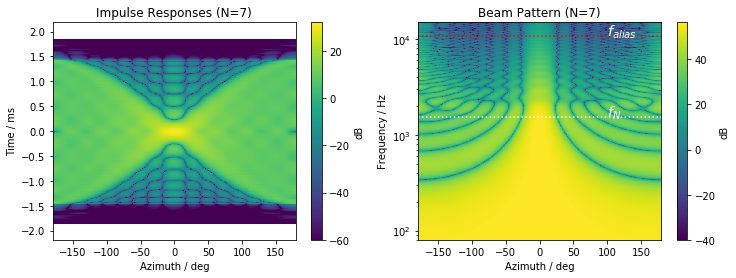

In [5]:
# Frequency responses
fmin, fmax, num_f = 80, 15000, 500
f = np.logspace(np.log10(fmin), np.log10(fmax), num=num_f)
Omega = 2 * np.pi * f / fs
V = np.column_stack([freqz(v_i, worN=Omega)[1] for v_i in v.T])

time = (np.arange(L + 2 * Lh) + overall_shift) / fs - R / c
tlim = np.array([-R / c, R / c]) * 3 * 1000
ir_vmin = -60
tf_vmin = -40

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

im = ax[0].pcolormesh(np.rad2deg(azi_l), time * 1000, db(v), vmin=ir_vmin)
ax[0].set_ylim(tlim)
ax[0].set_xlabel('Azimuth / deg')
ax[0].set_ylabel('Time / ms')
fig.colorbar(im, ax=ax[0]).set_label('dB')
ax[0].set_title('Impulse Responses (N={})'.format(bf_order))

im = ax[1].pcolormesh(np.rad2deg(azi_l), f, db(V), vmin=tf_vmin)
ax[1].plot(np.rad2deg(azi_l), f_alias * np.ones_like(azi_l), 'r:', label='$f_{array}$')
ax[1].plot(np.rad2deg(azi_l), f_N * np.ones_like(azi_l), 'w:', label='$f_{sht}$')
if f_alias < fmax: ax[1].text(100, f_alias, '$f_{alias}$', fontsize='x-large', color='w')
if f_N < fmax: ax[1].text(100, f_N, '$f_{N}$', fontsize='x-large', color='w')
ax[1].set_xlabel('Azimuth / deg')
ax[1].set_ylabel('Frequency / Hz')
ax[1].set_yscale('log')
ax[1].set_ylim([fmin, fmax])
fig.colorbar(im, ax=ax[1]).set_label('dB')
ax[1].set_title('Beam Pattern (N={})'.format(bf_order))

print('R = {R} m, # of mic = {Q}, array order = {array_order},\
      bf order = {bf_order}, fs = {fs}'
      .format(R=R, Q=Q, array_order=array_order, bf_order=bf_order, fs=fs))

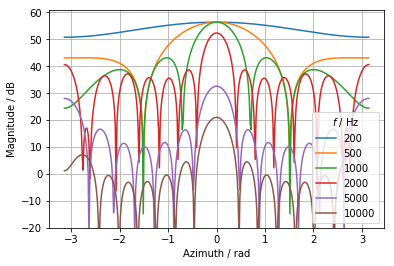

In [6]:
# Beam pattern
f = 200, 500, 1000, 2000, 5000, 10000  # frequencies

plt.figure()
[plt.plot(azi_l, db(freqz(v, worN=2 * np.pi * f_i / fs)[1]),
          label='{}'.format(f_i)) for f_i in f];
plt.xlabel('Azimuth / rad')
plt.ylabel('Magnitude / dB')
plt.legend(loc='lower right', title='$f$ / Hz')
plt.ylim(ymin=-20)
plt.grid()